In [1]:
import warnings

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")

rng = 0


In [2]:
# Loading of dataset, with data preprocessing
train_features = pd.read_csv('./data/train_features_modified.csv')
train_labels = pd.read_csv('./data/dengue_labels_train.csv')
test_features = pd.read_csv('./data/test_features_modified.csv')


In [3]:
# convert week_start_date column to datetime
train_features['week_start_date'] = pd.to_datetime(
    train_features['week_start_date'])
test_features['week_start_date'] = pd.to_datetime(
    test_features['week_start_date'])


In [4]:
# merging features and labels
train_features = pd.merge(train_features, train_labels, on=[
                          'city', 'year', 'weekofyear'])


In [5]:
# Seperate data for San Juan
sj_train_features = train_features[train_features.city == 'sj']
sj_train_labels = train_labels[train_labels.city == 'sj']
sj_test_features = test_features[test_features.city == 'sj'].drop(['city'], axis=1)

# Separate data for Iquitos
iq_train_features = train_features[train_features.city == 'iq']
iq_train_labels = train_labels[train_labels.city == 'iq']
iq_test_features = test_features[test_features.city == 'iq'].drop(['city'], axis=1)

# OneHotEncoder for categorical variables
enc = OneHotEncoder(handle_unknown='ignore')


## Classification


<AxesSubplot:xlabel='week_start_date'>

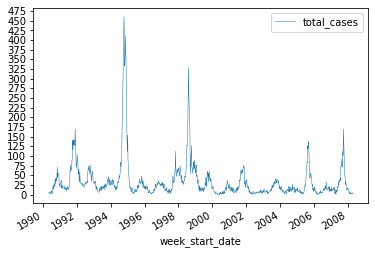

In [6]:
# San Juan histogram
sj_train_features.plot(x='week_start_date', y='total_cases',
                       linewidth=0.5, yticks=range(0, 500, 25))


From the graph, we can see that there are a few different peak values. They are around 50, 75, 150, 200, 325 and 500. We can use these peaks to split the values into, from 0 to 75, 75 to 150, 150 to 200, 200 to 350 and 350 to 500.


In [7]:
# slice sj_train_features into bins of intervals 0 to 25, 25 to 50
sj_train_features['range'] = pd.cut(
    sj_train_features['total_cases'], bins=[0, 50, 75, 150, 200, 350, 500], include_lowest=True)
# convert range to categories from 0 to 5
sj_train_features['range'] = sj_train_features['range'].cat.codes


<AxesSubplot:xlabel='week_start_date'>

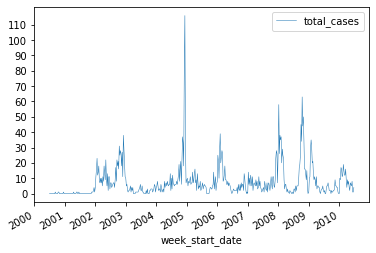

In [8]:
# San Juan histogram
iq_train_features.plot(x='week_start_date', y='total_cases',
                       linewidth=0.5, yticks=range(0, 120, 10))


From the graph, we can see that there are a few different peak values. They are around 10, 20, 40, 60 and 120. We can use these peaks to split the values into, from 0 to 10, 10 to 20, 20 to 40, 40 to 60, 60 to 150.


In [9]:
iq_train_features['range'] = pd.cut(
    iq_train_features['total_cases'], bins=[0, 10, 20, 40, 60, 150], include_lowest=True)

# convert range to categories from 0 to 5
iq_train_features['range'] = iq_train_features['range'].cat.codes


In [10]:
# build classifier model
def get_classifier_model(train_features):
    X = train_features.drop(['total_cases', 'range', 'city', 'week_start_date', 'year'], axis=1)
    y = train_features.range.values

    # build pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('selectkbest', SelectKBest()),
        ('randomforestclassifier', RandomForestClassifier(random_state=rng))
    ])

    # hyperparameter tuning for classification pipeline
    hyperparameters = {
        'selectkbest__k': np.arange(20, 80, 10),
        'randomforestclassifier__max_depth': np.arange(1, 10),
        'randomforestclassifier__n_estimators': np.arange(1, 100, 10)
    }

    # automated hyperparameter tuning
    grid_search = GridSearchCV(pipeline, hyperparameters, cv=5)
    grid_search.fit(X, y)

    # save best model
    return grid_search.best_estimator_


In [11]:
# build separate regression model for each range
def get_regression_models(train_features):
    range = train_features.range.unique()
    best_regressors = []
    for value in range:
        train_features_range = sj_train_features[sj_train_features.range == value]
        # build regression model
        X = train_features_range.drop(['total_cases', 'city', 'week_start_date', 'year'], axis=1)
        y = train_features_range.total_cases
        
        # build pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler(with_mean=False)),
            ('selectkbest', SelectKBest()),
            ('randomforestregressor', RandomForestRegressor(random_state=rng))
        ])

        # hyperparameter tuning for classification pipeline
        hyperparameters = {
            'selectkbest__k': np.arange(20, 80, 10),
            'randomforestregressor__max_depth': np.arange(1, 10),
            'randomforestregressor__n_estimators': np.arange(1, 100, 10)
        }

        # automated hyperparameter tuning
        grid_search = GridSearchCV(pipeline, hyperparameters, cv=5)
        grid_search.fit(X, y)

        # save best model
        best_regressors.append(grid_search.best_estimator_)
    return best_regressors


In [12]:
sj_best_classifier = get_classifier_model(sj_train_features)
sj_test_features = sj_test_features.drop(['week_start_date', 'year'], axis=1)
sj_test_features['range'] = sj_best_classifier.predict(sj_test_features)
sj_regression_models = get_regression_models(sj_train_features)


In [13]:
iq_best_classifier = get_classifier_model(iq_train_features)
iq_test_features = iq_test_features.drop(['week_start_date', 'year'], axis=1)
iq_test_features['range'] = iq_best_classifier.predict(iq_test_features)
iq_regression_models = get_regression_models(iq_test_features)


In [18]:
sj_predictions = []

# iterate through each row in sj_test_features
for index, row in sj_test_features.iterrows():
    # get range
    range = row['range'].astype(int)
    # predict total cases for current row
    prediction = sj_regression_models[range].predict(row.values.reshape(1, -1))[0]
    sj_predictions.append(prediction)


In [19]:
iq_predictions = []

# iterate through each row in iq_test_features
for index, row in iq_test_features.iterrows():
    # get range
    range = row['range'].astype(int)
    # predict total cases for current row
    prediction = iq_regression_models[range].predict(row.values.reshape(1, -1))[0]
    iq_predictions.append(prediction)
    

In [20]:
# combine predictions
predictions = sj_predictions + iq_predictions
# convert prediction to integer array
predictions = np.array(predictions, dtype=int)


In [21]:
submission = pd.read_csv("./data/submission_format.csv", index_col=[0, 1, 2])
submission.total_cases = predictions
submission.to_csv("./output/approach_3.csv")
